Ein realeres Beispiel fuer eine Auswertung mit Spark. Die Daten sind die Verspaetungsdaten 
des US Department of Transportation http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time

Adaptiert von https://districtdatalabs.silvrback.com/getting-started-with-spark-in-python,
nebenbei bemerkt, eine sehr schöne kurze Einführung in Spark mit python

Hello
-45442 minutes delayed	Alaska Airlines Inc.: AS
-20654 minutes delayed	Hawaiian Airlines Inc.: HA
39247 minutes delayed	AirTran Airways Corporation: FL
40841 minutes delayed	Virgin America: VX
108480 minutes delayed	Frontier Airlines Inc.: F9
177717 minutes delayed	US Airways Inc.: US
279981 minutes delayed	JetBlue Airways: B6
390614 minutes delayed	United Air Lines Inc.: UA
431755 minutes delayed	American Airlines Inc.: AA
461753 minutes delayed	Delta Air Lines Inc.: DL
493527 minutes delayed	Envoy Air: MQ
519867 minutes delayed	SkyWest Airlines Inc.: OO
1160058 minutes delayed	ExpressJet Airlines Inc.: EV
2181955 minutes delayed	Southwest Airlines Co.: WN


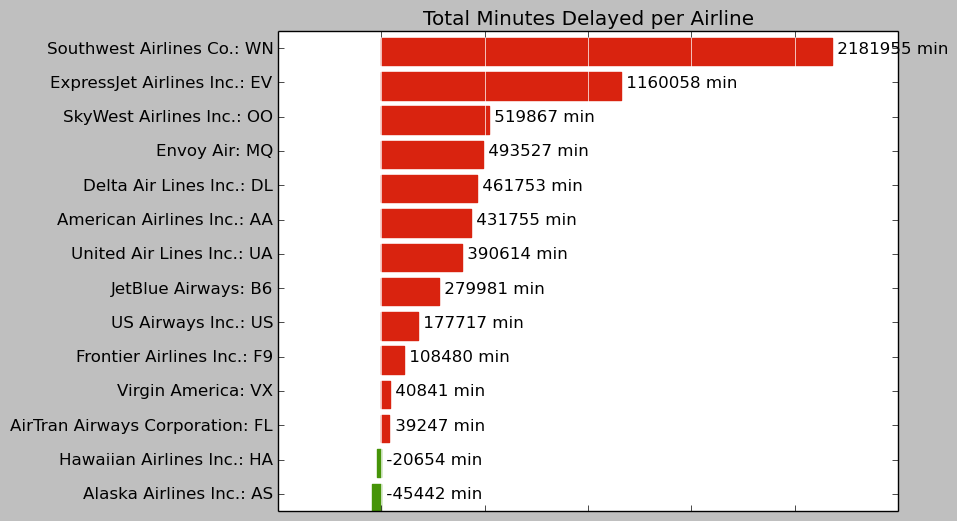

In [5]:
import csv
import matplotlib.pyplot as plt

from StringIO import StringIO
from datetime import datetime
from collections import namedtuple
from operator import add, itemgetter
from pyspark import SparkConf, SparkContext

%matplotlib inline  

## Module Constants
APP_NAME = "Flight Delay Analysis"
DATE_FMT = "%Y-%m-%d"
TIME_FMT = "%H%M"

fields   = ('date', 'airline', 'flightnum', 'origin', 'dest', 'dep',
            'dep_delay', 'arv', 'arv_delay', 'airtime', 'distance')
Flight   = namedtuple('Flight', fields)

## Closure Functions
def parse(row):
    """
    Parses a row and returns a named tuple.
    """

    row[0]  = datetime.strptime(row[0], DATE_FMT).date()
    row[5]  = datetime.strptime(row[5], TIME_FMT).time()
    row[6]  = float(row[6])
    row[7]  = datetime.strptime(row[7], TIME_FMT).time()
    row[8]  = float(row[8])
    row[9]  = float(row[9])
    row[10] = float(row[10])
    return Flight(*row[:11])

def split(line):
    """
    Operator function for splitting a line with csv module
    """
    reader = csv.reader(StringIO(line))
    return reader.next()

def plot(delays):
    """
    Show a bar chart of the total delay per airline
    """
    airlines = [d[0] for d in delays]
    minutes  = [d[1] for d in delays]
    index    = list(xrange(len(airlines)))

    fig, axe = plt.subplots()
    bars = axe.barh(index, minutes)

    # Add the total minutes to the right
    for idx, air, min in zip(index, airlines, minutes):
        if min > 0:
            bars[idx].set_color('#d9230f')
            axe.annotate(" %0.0f min" % min, xy=(min+1, idx+0.5), va='center')
        else:
            bars[idx].set_color('#469408')
            axe.annotate(" %0.0f min" % min, xy=(10, idx+0.5), va='center')

    # Set the ticks
    ticks = plt.yticks([idx+ 0.5 for idx in index], airlines)
    xt = plt.xticks()[0]
    plt.xticks(xt, [' '] * len(xt))

    # minimize chart junk
    plt.grid(axis = 'x', color ='white', linestyle='-')

    plt.title('Total Minutes Delayed per Airline')
    plt.show()

## Main functionality
def main(sc):

    # Load the airlines lookup dictionary
    airlines = dict(sc.textFile("ontime/airlines.csv").map(split).collect())

    # Broadcast the lookup dictionary to the cluster
    airline_lookup = sc.broadcast(airlines)

    # Read the CSV Data into an RDD
    flights = sc.textFile("ontime/flights.csv").map(split).map(parse)

    # Map the total delay to the airline (joined using the broadcast value)
    delays  = flights.map(lambda f: (airline_lookup.value[f.airline],
                                     add(f.dep_delay, f.arv_delay)))

    # Reduce the total delay for the month to the airline
    delays  = delays.reduceByKey(add).collect()
    delays  = sorted(delays, key=itemgetter(1))

    # Provide output from the driver
    for d in delays:
        print "%0.0f minutes delayed\t%s" % (d[1], d[0])

    # Show a bar chart of the delays
    plot(delays)

main(sc)